# 範例3. 使用CNN進行物件偵測
### 修改自 [Turning any CNN image classifier into an object detector with Keras, TensorFlow, and OpenCV - PyImageSearch](https://www.pyimagesearch.com/2020/06/22/turning-any-cnn-image-classifier-into-an-object-detector-with-keras-tensorflow-and-opencv/)

In [1]:
# 載入套件，需額外安裝 imutils 套件
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
import numpy as np
import imutils
import time
import cv2

In [2]:
# 參數設定
image_path = './bike.jpg'  # 要辨識的圖檔
WIDTH = 600              # 圖像縮放為 (600, 600)
PYR_SCALE = 1.5          # 影像金字塔縮放比例
WIN_STEP = 16            # 視窗滑動步數
ROI_SIZE = (250, 250)    # 視窗大小
INPUT_SIZE = (224, 224)  # CNN的輸入尺寸

In [3]:
# 載入 ResNet50 模型
model = ResNet50(weights="imagenet", include_top=True)

102967424/102967424 [==============================] - 0s 0us/step


In [4]:
# 讀取要辨識的圖片
orig = cv2.imread(image_path)
orig = imutils.resize(orig, width=WIDTH)
(H, W) = orig.shape[:2]

In [5]:
# 定義滑動視窗與影像金字塔函數

# 滑動視窗
def sliding_window(image, step, ws):
    for y in range(0, image.shape[0] - ws[1], step):     # 向下滑動 stepSize 格
        for x in range(0, image.shape[1] - ws[0], step): # 向右滑動 stepSize 格
            # 傳回裁剪後的視窗
            yield (x, y, image[y:y + ws[1], x:x + ws[0]])

# 影像金字塔操作
# image：原圖，scale：每次縮小倍數，minSize：最小尺寸
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # 第一次傳回原圖
    yield image

    # keep looping over the image pyramid
    while True:
        # 計算縮小後的尺寸
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)

        # 直到最小尺寸為止
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break

        # 傳回縮小後的圖像
        yield image

In [6]:
# 輸出候選框
rois = []    # 候選框
locs = []    # 位置
SHOW_BOX = False  # 是否顯示要找的框

# 產生影像金字塔
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
# 逐一視窗辨識
for image in pyramid:
    # 框與原圖的比例
    scale = W / float(image.shape[1])

    # 滑動視窗
    for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
        # 取得候選框
        x = int(x * scale)
        y = int(y * scale)
        w = int(ROI_SIZE[0] * scale)
        h = int(ROI_SIZE[1] * scale)

        # 縮放圖形以符合模型輸入規格
        roi = cv2.resize(roiOrig, INPUT_SIZE)
        roi = img_to_array(roi)
        roi = preprocess_input(roi)

        # 加入輸出變數中
        rois.append(roi)
        locs.append((x, y, x + w, y + h))

        # 是否顯示要找的框
        if SHOW_BOX:
            clone = orig.copy()
            cv2.rectangle(clone, (x, y), (x + w, y + h),
                (0, 255, 0), 2)

            # 顯示正在找的框
            cv2.imshow("Visualization", clone)
            cv2.imshow("ROI", roiOrig)
            cv2.waitKey(0)

cv2.destroyAllWindows()

8/8 [==============================] - 39s 5s/step


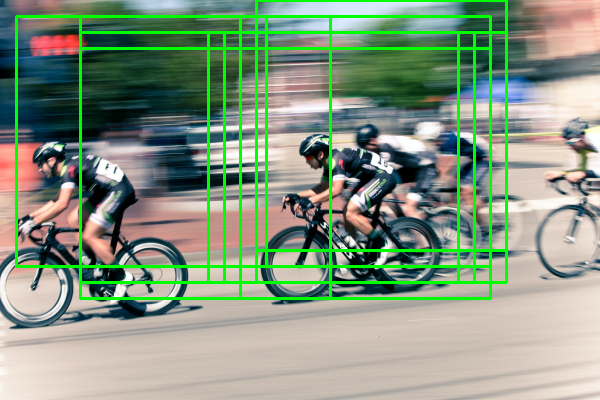

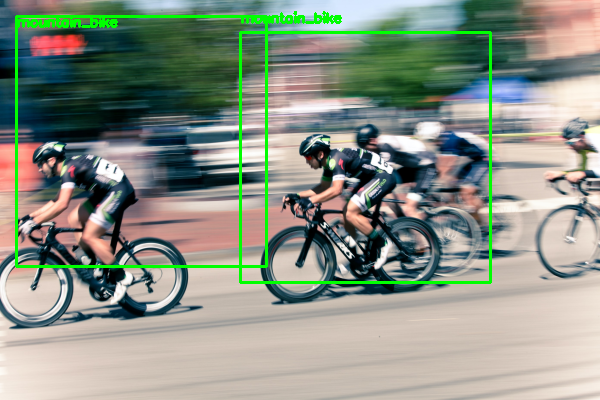

In [8]:
from google.colab.patches import cv2_imshow
# 預測
MIN_CONFIDENCE = 0.9  # 辨識機率門檻值

rois = np.array(rois, dtype="float32")
preds = model.predict(rois)
preds = imagenet_utils.decode_predictions(preds, top=1)
labels = {}

# 檢查預測結果，辨識機率須大於設定值
for (i, p) in enumerate(preds):
    # grab the prediction information for the current ROI
    (imagenetID, label, prob) = p[0]

    # 機率大於設定值，則放入候選名單
    if prob >= MIN_CONFIDENCE:
        # 放入候選名單
        box = locs[i]
        L = labels.get(label, [])
        L.append((box, prob))
        labels[label] = L

# 掃描每一個類別
for label in labels.keys():
    # 複製原圖
    clone = orig.copy()

    # 畫框
    for (box, prob) in labels[label]:
        (startX, startY, endX, endY) = box
        cv2.rectangle(clone, (startX, startY), (endX, endY),
            (0, 255, 0), 2)

    # 顯示 NMS(non-maxima suppression) 前的框
    cv2_imshow( clone)
    clone = orig.copy()

    # NMS
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, proba)

    for (startX, startY, endX, endY) in boxes:
        # 畫框及類別
        cv2.rectangle(clone, (startX, startY), (endX, endY), (0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(clone, label, (startX, y),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

    # 顯示
    cv2_imshow( clone)
    cv2.waitKey(0)

cv2.destroyAllWindows()    # 關閉所有視窗